In [1]:
import numpy as np
import torch
from torch import nn,optim

In [2]:
def load_data():
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    seq_number = np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.], dtype=np.float32)
    # assert seq_number.shape == (144, )
    # plt.plot(seq_number)
    # plt.ion()
    # plt.pause(1)
    seq_number = seq_number[:, np.newaxis]

    # print(repr(seq))
    # 1949~1960, 12 years, 12*12==144 month
    seq_year = np.arange(12)
    seq_month = np.arange(12)
    seq_year_month = np.transpose(
        [np.repeat(seq_year, len(seq_month)),
         np.tile(seq_month, len(seq_year))],
    )  # Cartesian Product

    seq = np.concatenate((seq_number, seq_year_month), axis=1)

    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    return seq

In [3]:
def run_train_lstm():
    inp_dim = 3
    out_dim = 1
    mid_dim = 8
    mid_layers = 1
    batch_size = 12 * 4
    mod_dir = '.'

    '''load data'''
    data = load_data()
    data_x = data[:-1, :]
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    print("Training Start")
    for e in range(384):
        out = net(batch_var_x)
    
        # loss = criterion(out, batch_var_y)
        loss = (out - batch_var_y) ** 2 * weights
        loss = loss.mean()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if e % 64 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
    print("Save in:", '{}/net.pth'.format(mod_dir))

    '''eval'''
    net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

    '''simple way but no elegant'''
    # for i in range(train_size, len(data) - 2):
    #     test_y = net(test_x[:i])
    #     test_x[i, 0, 0] = test_y[-1]

    '''elegant way but slightly complicated'''
    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
    test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
    test_x[train_size + 1, 0, 0] = test_y[-1]
    for i in range(train_size + 1, len(data) - 2):
        test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
        test_x[i + 1, 0, 0] = test_y[-1]
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
    plt.legend(loc='best')
    plt.savefig('lstm_reg.png')
    plt.pause(4)

In [4]:
data = load_data()
data_x = data[:-1, :]
data_y = data[+1:, 0]

In [5]:
data.shape

(144, 3)

In [6]:
data

array([[-1.40777884, -1.59325501, -1.59325501],
       [-1.35759023, -1.59325501, -1.30357228],
       [-1.24048348, -1.59325501, -1.01388955],
       [-1.26557778, -1.59325501, -0.72420682],
       [-1.33249593, -1.59325501, -0.43452409],
       [-1.21538918, -1.59325501, -0.14484136],
       [-1.10664719, -1.59325501,  0.14484136],
       [-1.10664719, -1.59325501,  0.43452409],
       [-1.20702441, -1.59325501,  0.72420682],
       [-1.34922546, -1.59325501,  1.01388955],
       [-1.47469699, -1.59325501,  1.30357228],
       [-1.35759023, -1.59325501,  1.59325501],
       [-1.38268454, -1.30357228, -1.59325501],
       [-1.29067209, -1.30357228, -1.30357228],
       [-1.16520057, -1.30357228, -1.01388955],
       [-1.21538918, -1.30357228, -0.72420682],
       [-1.29903686, -1.30357228, -0.43452409],
       [-1.09828242, -1.30357228, -0.14484136],
       [-0.9226223 , -1.30357228,  0.14484136],
       [-0.9226223 , -1.30357228,  0.43452409],
       [-1.02299951, -1.30357228,  0.724

In [7]:
data_x

array([[-1.40777884, -1.59325501, -1.59325501],
       [-1.35759023, -1.59325501, -1.30357228],
       [-1.24048348, -1.59325501, -1.01388955],
       [-1.26557778, -1.59325501, -0.72420682],
       [-1.33249593, -1.59325501, -0.43452409],
       [-1.21538918, -1.59325501, -0.14484136],
       [-1.10664719, -1.59325501,  0.14484136],
       [-1.10664719, -1.59325501,  0.43452409],
       [-1.20702441, -1.59325501,  0.72420682],
       [-1.34922546, -1.59325501,  1.01388955],
       [-1.47469699, -1.59325501,  1.30357228],
       [-1.35759023, -1.59325501,  1.59325501],
       [-1.38268454, -1.30357228, -1.59325501],
       [-1.29067209, -1.30357228, -1.30357228],
       [-1.16520057, -1.30357228, -1.01388955],
       [-1.21538918, -1.30357228, -0.72420682],
       [-1.29903686, -1.30357228, -0.43452409],
       [-1.09828242, -1.30357228, -0.14484136],
       [-0.9226223 , -1.30357228,  0.14484136],
       [-0.9226223 , -1.30357228,  0.43452409],
       [-1.02299951, -1.30357228,  0.724

In [10]:
data_x.shape

(143, 3)

In [9]:
data_y.shape

(143,)

In [8]:
data_y

array([-1.35759023, -1.24048348, -1.26557778, -1.33249593, -1.21538918,
       -1.10664719, -1.10664719, -1.20702441, -1.34922546, -1.47469699,
       -1.35759023, -1.38268454, -1.29067209, -1.16520057, -1.21538918,
       -1.29903686, -1.09828242, -0.9226223 , -0.9226223 , -1.02299951,
       -1.23211871, -1.3910493 , -1.17356534, -1.1317415 , -1.08991766,
       -0.85570415, -0.98117567, -0.90589276, -0.85570415, -0.68004402,
       -0.68004402, -0.80551554, -0.98954044, -1.12337673, -0.95608137,
       -0.91425753, -0.83897462, -0.73023263, -0.83060985, -0.81388031,
       -0.52111343, -0.42073621, -0.320359  , -0.59639634, -0.74696217,
       -0.90589276, -0.72186786, -0.70513833, -0.70513833, -0.37054761,
       -0.37891237, -0.42910098, -0.31199423, -0.1363341 , -0.06941596,
       -0.36218284, -0.57966681, -0.83897462, -0.66331449, -0.63822018,
       -0.77205647, -0.37891237, -0.44583052, -0.38727714, -0.1363341 ,
        0.18152708,  0.10624417, -0.17815794, -0.42910098, -0.64

In [11]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

In [ ]:
    inp_dim = 3
    out_dim = 1
    mid_dim = 8
    mid_layers = 1
    batch_size = 12 * 4
    mod_dir = '.'

In [24]:
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt

"""
Github: Yonv1943 Zen4 Jia1 hao2
https://github.com/Yonv1943/DL_RL_Zoo/blob/master/RNN
The source of training data 
https://github.com/L1aoXingyu/
code-of-learn-deep-learning-with-pytorch/blob/master/
chapter5_RNN/time-series/lstm-time-series.ipynb
"""


def run_train_gru():
    inp_dim = 3
    out_dim = 1
    batch_size = 12 * 4

    '''load data'''
    data = load_data()
    data_x = data[:-1, :]
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegGRU(inp_dim, out_dim, mod_dim=12, mid_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

    batch_var_x = list()
    batch_var_y = list()

    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    for e in range(256):
        out = net(batch_var_x)

        # loss = criterion(out, batch_var_y)
        loss = (out - batch_var_y) ** 2 * weights
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 100 == 0:
            print('Epoch: {}, Loss: {:.5f}'.format(e, loss.item()))

    '''eval'''
    net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
    for i in range(train_size, len(data) - 2):
        test_y = net(test_x[:i])
        test_x[i + 1, 0, 0] = test_y[-1]
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))
    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real')
    plt.legend(loc='best')
    plt.pause(4)


def run_train_lstm():
    inp_dim = 3
    out_dim = 1
    mid_dim = 8
    mid_layers = 1
    batch_size = 12 * 4
    mod_dir = '.'

    '''load data'''
    data = load_data()
    data_x = data[:-1, :]
    data_y = data[+1:, 0]
    assert data_x.shape[1] == inp_dim

    train_size = int(len(data_x) * 0.75)

    train_x = data_x[:train_size]
    train_y = data_y[:train_size]
    train_x = train_x.reshape((train_size, inp_dim))
    train_y = train_y.reshape((train_size, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
    

    batch_var_x = list()
    batch_var_y = list()
    
    print('var_x shape : ',var_x.shape)
    print('var_y shape : ',var_y.shape)
    print('train size : ',train_size)

    for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(var_x[j:])
        batch_var_y.append(var_y[j:])
    print('batch_var_x len',len(batch_var_x))
    print('batch_var_x shape',len(batch_var_x[0].shape))
    print('batch_var_y len',len(batch_var_y))

    from torch.nn.utils.rnn import pad_sequence
    batch_var_x = pad_sequence(batch_var_x)
    batch_var_y = pad_sequence(batch_var_y)

    with torch.no_grad():
        weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

    print("Training Start")
    for e in range(384):
#         print('batch_var_x:',len(batch_var_x))
        print('batch_var_x shape :',batch_var_x.shape)
        print('batch_var_y shape :',batch_var_y.shape)
        out = net(batch_var_x)
    
        # loss = criterion(out, batch_var_y)
        loss = (out - batch_var_y) ** 2 * weights
        loss = loss.mean()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if e % 64 == 0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
    print("Save in:", '{}/net.pth'.format(mod_dir))

    '''eval'''
    net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()

    test_x = data_x.copy()
    test_x[train_size:, 0] = 0
    test_x = test_x[:, np.newaxis, :]
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

    '''simple way but no elegant'''
    # for i in range(train_size, len(data) - 2):
    #     test_y = net(test_x[:i])
    #     test_x[i, 0, 0] = test_y[-1]

    '''elegant way but slightly complicated'''
    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
    test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
    test_x[train_size + 1, 0, 0] = test_y[-1]
    for i in range(train_size + 1, len(data) - 2):
        test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
        test_x[i + 1, 0, 0] = test_y[-1]
    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:-1]
    l1_loss = np.mean(np.abs(diff_y))
    l2_loss = np.mean(diff_y ** 2)
    print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

    plt.plot(pred_y, 'r', label='pred')
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], color='k', label='train | pred')
    plt.legend(loc='best')
    plt.savefig('lstm_reg.png')
    plt.pause(4)


def run_origin():
    inp_dim = 2
    out_dim = 1
    mod_dir = '.'

    '''load data'''
    data = load_data()  # axis1: number, year, month
    data_x = np.concatenate((data[:-2, 0:1], data[+1:-1, 0:1]), axis=1)
    data_y = data[2:, 0]

    train_size = int(len(data_x) * 0.75)
    train_x = data_x[:train_size]
    train_y = data_y[:train_size]

    train_x = train_x.reshape((-1, 1, inp_dim))
    train_y = train_y.reshape((-1, 1, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim=4, mid_layers=2).to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
    print('var_x.size():', var_x.size())
    print('var_y.size():', var_y.size())

    for e in range(512):
        out = net(var_x)
        loss = criterion(out, var_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (e + 1) % 100 == 0:  # 每 100 次输出结果
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))

    '''eval'''
    # net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()  # 转换成测试模式

    """
    inappropriate way of seq prediction: 
    use all real data to predict the number of next month
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    var_data = torch.tensor(test_x, dtype=torch.float32, device=device)
    eval_y = net(var_data)  # 测试集的预测结果
    pred_y = eval_y.view(-1).cpu().data.numpy()

    plt.plot(pred_y[1:], 'r', label='pred inappr', alpha=0.3)
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], label='train | pred')

    """
    appropriate way of seq prediction: 
    use real+pred data to predict the number of next 3 years.
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    test_x[train_size:] = 0  # delete the data of next 3 years.
    test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
    for i in range(train_size, len(data) - 2):
        test_y = net(test_x[:i])
        test_x[i, 0, 0] = test_x[i - 1, 0, 1]
        test_x[i, 0, 1] = test_y[-1, 0]
    pred_y = test_x.cpu().data.numpy()
    pred_y = pred_y[:, 0, 0]
    plt.plot(pred_y[2:], 'g', label='pred appr')

    plt.legend(loc='best')
    plt.savefig('lstm_origin.png')
    plt.pause(4)


class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc


class RegGRU(nn.Module):
    def __init__(self, inp_dim, out_dim, mod_dim, mid_layers):
        super(RegGRU, self).__init__()

        self.rnn = nn.GRU(inp_dim, mod_dim, mid_layers)
        self.reg = nn.Linear(mod_dim, out_dim)

    def forward(self, x):
        x, h = self.rnn(x)  # (seq, batch, hidden)

        seq_len, batch_size, hid_dim = x.shape
        x = x.view(-1, hid_dim)
        x = self.reg(x)
        x = x.view(seq_len, batch_size, -1)
        return x

    def output_y_h(self, x, h):
        y, h = self.rnn(x, h)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, h


def load_data():
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    seq_number = np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.], dtype=np.float32)
    # assert seq_number.shape == (144, )
    # plt.plot(seq_number)
    # plt.ion()
    # plt.pause(1)
    seq_number = seq_number[:, np.newaxis]

    # print(repr(seq))
    # 1949~1960, 12 years, 12*12==144 month
    seq_year = np.arange(12)
    seq_month = np.arange(12)
    seq_year_month = np.transpose(
        [np.repeat(seq_year, len(seq_month)),
         np.tile(seq_month, len(seq_year))],
    )  # Cartesian Product

    seq = np.concatenate((seq_number, seq_year_month), axis=1)

    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    return seq


var_x shape :  torch.Size([107, 3])
var_x shape :  torch.Size([107, 3])
train size :  107
batch_var_x len 48
batch_var_x shape 2
batch_var_y len 48
Training Start
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
Epoch:    0, Loss: 0.23693
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape 

batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([

batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([

batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([47, 48, 3])
batch_var_y shape : torch.Size([47, 48, 1])
batch_var_x shape : torch.Size([

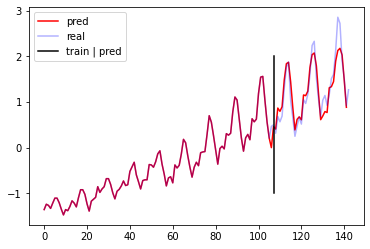

KeyboardInterrupt: 

In [25]:
if __name__ == '__main__':
    run_train_lstm()
    # run_train_gru()
    # run_origin()

In [17]:
144*0.75

108.0